In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import cv2
from matplotlib import pyplot as plt
import os
import shutil
import numpy as np
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
import random

# tensorflow library for our deep learning and CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import metrics

In [7]:
current_dir = os.getcwd()
print("Current Working Directory:", current_dir)
new_directory = '/content/drive/My Drive/IT1244/experimental'
os.chdir(new_directory)
print("New Current Working Directory:", os.getcwd())

Current Working Directory: /content
New Current Working Directory: /content/drive/My Drive/IT1244/experimental


In [8]:
classes=set()

if not os.listdir("data_classes"):
    for image in os.listdir("../images"):
        classes.add(image[:2])

    #the following code extracts the numerical part of the class name
    #this is because some of the numeric values are 1 digit and will leave an underscore behind in the string
    #this would filter out the numeric portion
    newlist=[int(''.join(filter(str.isdigit, classname))) for classname in classes]


    parent_dir="../experimental/data_classes"
    imagePath="../images"

    for num in (newlist):
        dir_path = os.path.join(parent_dir, str(num))
        os.makedirs(dir_path, exist_ok=True)
        print(f"Directory {dir_path} created.")


    for imagefilename in os.listdir(imagePath):
        newstring = "".join(filter(str.isdigit, imagefilename[:2]))
        targetdirectory=os.path.join(parent_dir, newstring)
        newimagepath=os.path.join(imagePath, imagefilename)
        shutil.copy(newimagepath, targetdirectory)
        print("image moved")

In [9]:
# we did this because there are some subfolders such as subfolder 22 which has lesser data than the other subfolders
# we want to increase the number of images in these kinds of subfolders
# we augment the new image data before adding it to those subfolders
add_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

base_dir = '../experimental/data_classes'

# we choose 514 because the max number of images among the classes is 514
target_count = 400
for class_num in range(23):
    class_dir = os.path.join(base_dir, str(class_num))
    images = os.listdir(class_dir)
    current_count = len(images)

    # this is for the subfolders that have insufficient iamges, so we top up with augmented images
    if current_count < target_count:
        print(f"Augmenting class {class_num} with {target_count - current_count} new images.")

        #this is because we want to top out the number of images in each class folders from 0 to  22
        images_needed = target_count - current_count

        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            generated_images = 0
            for batch in add_datagen.flow(x, batch_size=1, save_to_dir=class_dir, save_format='png'):
                generated_images += 1
                current_count += 1

                if current_count >= target_count:
                    break
            if current_count >= target_count:
                break

    # this is for subfolders such as subfolder 0 cos we want to cut down on the images so that all subfolders have 400 images
    elif current_count > target_count:
        images_to_remove = current_count - target_count
        print(f"Reducing class {class_num} by removing {images_to_remove} images.")
        images_to_delete = random.sample(images, images_to_remove)
        for img_name in images_to_delete:
            img_path = os.path.join(class_dir, img_name)
            os.remove(img_path)


Reducing class 0 by removing 114 images.
Reducing class 1 by removing 100 images.
Augmenting class 2 with 56 new images.
Augmenting class 3 with 132 new images.
Augmenting class 4 with 140 new images.
Augmenting class 5 with 156 new images.
Augmenting class 6 with 180 new images.
Augmenting class 7 with 182 new images.
Augmenting class 8 with 186 new images.
Augmenting class 9 with 198 new images.
Augmenting class 10 with 198 new images.
Augmenting class 11 with 202 new images.
Augmenting class 12 with 216 new images.
Augmenting class 13 with 244 new images.
Augmenting class 14 with 250 new images.
Augmenting class 15 with 260 new images.
Augmenting class 16 with 260 new images.
Augmenting class 17 with 268 new images.
Augmenting class 18 with 270 new images.
Augmenting class 19 with 272 new images.
Augmenting class 20 with 274 new images.
Augmenting class 21 with 282 new images.
Augmenting class 22 with 292 new images.


#### verifying the number of images in each subclass

In [10]:
for class_num in range(23):
    class_dir = os.path.join(base_dir, str(class_num))
    images = os.listdir(class_dir)
    print(f"Class {class_num} now has {len(images)} images.")

Class 0 now has 400 images.
Class 1 now has 400 images.
Class 2 now has 400 images.
Class 3 now has 400 images.
Class 4 now has 400 images.
Class 5 now has 397 images.
Class 6 now has 399 images.
Class 7 now has 396 images.
Class 8 now has 397 images.
Class 9 now has 399 images.
Class 10 now has 398 images.
Class 11 now has 396 images.
Class 12 now has 399 images.
Class 13 now has 396 images.
Class 14 now has 396 images.
Class 15 now has 398 images.
Class 16 now has 396 images.
Class 17 now has 397 images.
Class 18 now has 394 images.
Class 19 now has 398 images.
Class 20 now has 398 images.
Class 21 now has 399 images.
Class 22 now has 394 images.


In [11]:
# we want to split the data into train, val, test
# to do so we split the data such that 70% of the data are in training, 20% are in validation and 10% are in testing
# we spilt the image data into new folders as shown below
original_dir = '../experimental/data_classes'
train_dir = '../experimental/new/train'
val_dir = '../experimental/new/validation'
test_dir = '../experimental/new/test'

for i in range(23):
    os.makedirs(os.path.join(train_dir, str(i)), exist_ok=True)
    os.makedirs(os.path.join(val_dir, str(i)), exist_ok=True)
    os.makedirs(os.path.join(test_dir, str(i)), exist_ok=True)

for i in range(23):
    class_path = os.path.join(original_dir, str(i))
    images = os.listdir(class_path)
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=1/3, random_state=42)

# I think that copy files might be more time consuming than moving
# But I chose to copy instead of move because mistakes can be made
# hence, when mistakes are made to the train, validation and test folders, I still have the images in teh data_classes that I can copy over to these 3 folders
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, str(i)))
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, str(i)))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, str(i)))


In [12]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=256,
    class_mode='sparse',
    shuffle = True
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128,128),
    batch_size=256,
    class_mode='sparse',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=256,
    class_mode='sparse',
    shuffle=True
)

Found 6394 images belonging to 23 classes.
Found 1833 images belonging to 23 classes.
Found 920 images belonging to 23 classes.


In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [86]:
train_generator.class_indices

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '3': 16,
 '4': 17,
 '5': 18,
 '6': 19,
 '7': 20,
 '8': 21,
 '9': 22}

In [87]:
val_generator.class_indices

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '3': 16,
 '4': 17,
 '5': 18,
 '6': 19,
 '7': 20,
 '8': 21,
 '9': 22}

In [89]:
# it is important that the third argument is a string
# this is because if you look at the train_generator.class_indices which outputs a dictionary, the key is a string which represents the subfolder label under the data_classes directory
def testing_model(model, test_generator, class_of_interest = "6"):
    y_true = []
    y_pred = []

    class_indices = test_generator.class_indices
    index_to_class = {v: k for k, v in class_indices.items()}


    if class_of_interest in class_indices:
        class_of_interest = class_indices[class_of_interest]
    else:
        raise ValueError(f"Class '{class_of_interest}' not found in test_generator.class_indices")

    num_batches = len(test_generator)

    for _ in range(num_batches):
        images, labels = next(test_generator)

        # Get predictions
        predictions = model.predict(images)
        predicted_indices = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

        # Append true and predicted labels
        y_true.extend(labels if not isinstance(labels, tf.Tensor) else labels.numpy())
        y_pred.extend(predicted_indices)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    false_negatives = np.sum((y_true == class_of_interest) & (y_pred != class_of_interest))
    total_positives = np.sum(y_true == class_of_interest)
    false_negative_rate = false_negatives / total_positives if total_positives > 0 else 0

    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

    class_name = index_to_class.get(class_of_interest, str(class_of_interest))  # Get class name or index if not found
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"False Negative Rate for class '{class_name}' (index {class_of_interest}): {false_negative_rate:.4f}")


In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.GaussianNoise(0.1)
])

In [92]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    data_augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(23, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 31, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 31, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │      14,746,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 23)                  │          11,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,854,103 (56.66 MB)

 Trainable params: 14,852,631 (56.66 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [93]:
hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.0434 - loss: 4.4332 - val_accuracy: 0.0436 - val_loss: 3.7325
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.0494 - loss: 3.8727 - val_accuracy: 0.0436 - val_loss: 3.9094
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.0439 - loss: 3.7946 - val_accuracy: 0.0436 - val_loss: 5.2462
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.0448 - loss: 3.7555 - val_accuracy: 0.0436 - val_loss: 4.1667
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.0476 - loss: 3.6850 - val_accuracy: 0.0436 - val_loss: 5.6537
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.0440 - loss: 3.6508 - val_accuracy: 0.0436 - val_loss: 4.1586
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0381 - loss: 3.6352 - val_accuracy: 0.0436 - val_loss: 3.4628
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.0396 - loss: 3.5857 - val_accuracy: 0.0436 - val_loss:

In [94]:
testing_model(model, test_generator, "6")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0419 - loss: 7.9830
Test Loss: 7.9184
Test Accuracy: 0.0435
False Negative Rate for class '6' (index 19): 0.0000
Sample true labels (y_true): [16. 13. 22.  8.  2. 12. 19. 15. 16.  2.]
Sample predicted labels (y_pred as indices): [19 19 19 19 19 19 19 19 19 19]
Sample predicted labels (mapped back to original class names): ['6', '6', '6', '6', '6', '6', '6', '6', '6', '6']


In [97]:
import keras
import torch
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import MobileNetV2

base_model2 = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128, 3)
)

# we freeze to prevent the model from updating the weights because we want to see how the pretrained model performs
base_model2.trainable = False
inputs1 = keras.Input(shape=(128,128, 3))
x2 = data_augmentation(inputs1)
x2 = base_model2(inputs1, training=False)
x2 = keras.layers.GlobalAveragePooling2D()(x2)
outputs1 = keras.layers.Dense(23, activation="softmax")(x2)

model2 = keras.Model(inputs1, outputs1)
model2.summary(show_trainable=True)

model2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Training the last layer of Model 1 on the training data:")
mobilenetv2_hist = model2.fit(train_generator, epochs=10, validation_data=val_generator)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_46 (InputLayer)         │ (None, 128, 128, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mobilenetv2_1.00_128 (Functional)   │ (None, 4, 4, 1280)           │     2,257,984 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_18         │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_31 (Dense)                    │ (None, 23)                   │        29,463 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 2,287,447 (8.73 MB)

 Trainable params: 29,463 (115.09 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training the last layer of Model 1 on the training data:
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3777 - loss: 2.3119 - val_accuracy: 0.8292 - val_loss: 0.6897
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8843 - loss: 0.4979 - val_accuracy: 0.8958 - val_loss: 0.3882
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9316 - loss: 0.2990 - val_accuracy: 0.9307 - val_loss: 0.2834
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9616 - loss: 0.2013 - val_accuracy: 0.9482 - val_loss: 0.2239
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9739 - loss: 0.1566 - val_accuracy: 0.9558 - val_loss: 0.1866
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9764 - loss: 0.1292 - val_accuracy: 0.9645 - val_loss: 0.1577
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9854 - loss: 0.1044 - val_accuracy: 0.9733 - val_loss: 0.1349
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy:

In [98]:
testing_model(model2, test_generator, "6")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 538ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9821 - loss: 0.0990
Test Loss: 0.1048
Test Accuracy: 0.9783
False Negative Rate for class '6' (index 19): 0.0000
Sample true labels (y_true): [10. 14. 20.  9. 17. 15.  4.  0. 22.  3.]
Sample predicted labels (y_pred as indices): [10 14 20  9 17 15  4  0 22  3]
Sample predicted labels (mapped back to original class names): ['18', '21', '7', '17', '4', '22', '12', '0', '9', '11']


In [107]:
# Model 3: mobilenetv2 with finetuning
base_model3 = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

base_model3.trainable = False

inputs3 = keras.Input(shape=(128, 128, 3))
x3 = base_model3(inputs3, training=False)
x3 = keras.layers.GlobalAveragePooling2D()(x3)
outputs3 = keras.layers.Dense(23, activation="softmax")(x3)

model3 = keras.Model(inputs3, outputs3)

# we unfreeze the last 10 layers of mobilenetv2 for finetuning
for layer in base_model3.layers[-10:]:
    layer.trainable = True

model3.summary(show_trainable = True)
model3.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy"
    ]
)

print("Fine-tuning MobileNetv2...")
mobilenetv2_finetune_hist = model3.fit(train_generator, epochs=10, validation_data=val_generator)


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_48 (InputLayer)         │ (None, 128, 128, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mobilenetv2_1.00_128 (Functional)   │ (None, 4, 4, 1280)           │     2,257,984 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_19         │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_32 (Dense)                    │ (None, 23)                   │        29,463 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 2,287,447 (8.73 MB)

 Trainable params: 761,943 (2.91 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

Fine-tuning MobileNetv2...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.7467 - loss: 0.9293 - val_accuracy: 0.7398 - val_loss: 1.1084
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9959 - loss: 0.0248 - val_accuracy: 0.6710 - val_loss: 1.6285
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9989 - loss: 0.0064 - val_accuracy: 0.7310 - val_loss: 1.1290
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.7327 - val_loss: 1.1179
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.7414 - val_loss: 1.0320
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 6.7422e-04 - val_accuracy: 0.7567 - val_loss: 0.9582
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 5.3405e-04 - val_accuracy: 0.7812 - val_loss: 0.8586
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 1.0000 - loss: 4.445

In [108]:
testing_model(model3, test_generator, "6")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 551ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8698 - loss: 0.5481
Test Loss: 0.5509
Test Accuracy: 0.8620
False Negative Rate for class '6' (index 19): 0.0256
Sample true labels (y_true): [12.  1. 11.  6. 21. 12. 11. 21. 21. 18.]
Sample predicted labels (y_pred as indices): [12 12 11  6 21 12 11 21 21 18]
Sample predicted labels (mapped back to original class names): ['2', '2', '19', '14', '8', '2', '19', '8', '8', '5']


In [48]:
from tensorflow.keras.applications import ResNet50

resnet_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
)

resnet_model.trainable = False
inputs4 = keras.Input(shape = (128,128,3))
x4 = resnet_model(inputs4, training = False)
x4 = GlobalAveragePooling2D()(x4)
x4 = Dropout(0.2)(x4)
outputs4 = Dense(23, activation = "softmax")(x4)
model4 = keras.Model(inputs4, outputs4)
model4.summary(show_trainable=True)
model4.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy"
    ]
)

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_34 (InputLayer)         │ (None, 128, 128, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ resnet50 (Functional)               │ (None, 4, 4, 2048)           │    23,587,712 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_13         │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_19 (Dropout)                │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_22 (Dense)                    │ (None, 23)                   │        47,127 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 23,634,839 (90.16 MB)

 Trainable params: 47,127 (184.09 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [111]:
hist4 = model4.fit(train_generator, epochs = 10, validation_data = val_generator)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4795 - loss: 2.5175 - val_accuracy: 0.5925 - val_loss: 2.5167
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4829 - loss: 2.4822 - val_accuracy: 0.5586 - val_loss: 2.4804
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4952 - loss: 2.4486 - val_accuracy: 0.5696 - val_loss: 2.4478
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5116 - loss: 2.3978 - val_accuracy: 0.5837 - val_loss: 2.4142
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5105 - loss: 2.3739 - val_accuracy: 0.5510 - val_loss: 2.3844
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5078 - loss: 2.3523 - val_accuracy: 0.5690 - val_loss: 2.3566
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5260 - loss: 2.3116 - val_accuracy: 0.5646 - val_loss: 2.3285
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5153 - loss: 2.3053 - val_accuracy: 0.5990 - val_loss:

In [83]:
testing_model(model4, test_generator, "6")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 844ms/step - accuracy: 0.5378 - loss: 2.5391
Test Loss: 2.5385
Test Accuracy: 0.5337
False Negative Rate for class '6' (index 19): 0.3500
Sample true labels (y_true): [13. 11.  0.  0.  1. 13.  1. 16.  0.  1.]
Sample predicted labels (y_pred as indices): [ 0 11  0  0  1  0  1  8  0  1]
Sample predicted labels (mapped back to original class names): ['0', '19', '0', '0', '1', '0', '1', '16', '0', '1']


# Saving models

In [99]:
model.save("vanilla_model.keras")

In [100]:
model2.save("mobilenetv2_pretrained.keras")

In [101]:
model3.save("mobilenetv2_finetuning.keras")

In [102]:
model4.save("resnet_pretrained.keras")

# Plotting out graphs

In [103]:
def plot_loss_and_accuracy(hist):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Loss
    axes[0].plot(hist.history['loss'], color='teal', label='Loss')
    axes[0].plot(hist.history['val_loss'], color='orange', label='Val Loss')
    axes[0].set_title('Loss', fontsize=16)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss Value')
    axes[0].legend(loc="upper left")

    # Plot Accuracy
    axes[1].plot(hist.history['accuracy'], color='teal', label='Accuracy')
    axes[1].plot(hist.history['val_accuracy'], color='orange', label='Val Accuracy')
    axes[1].set_title('Accuracy', fontsize=16)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy Value')
    axes[1].legend(loc="upper left")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


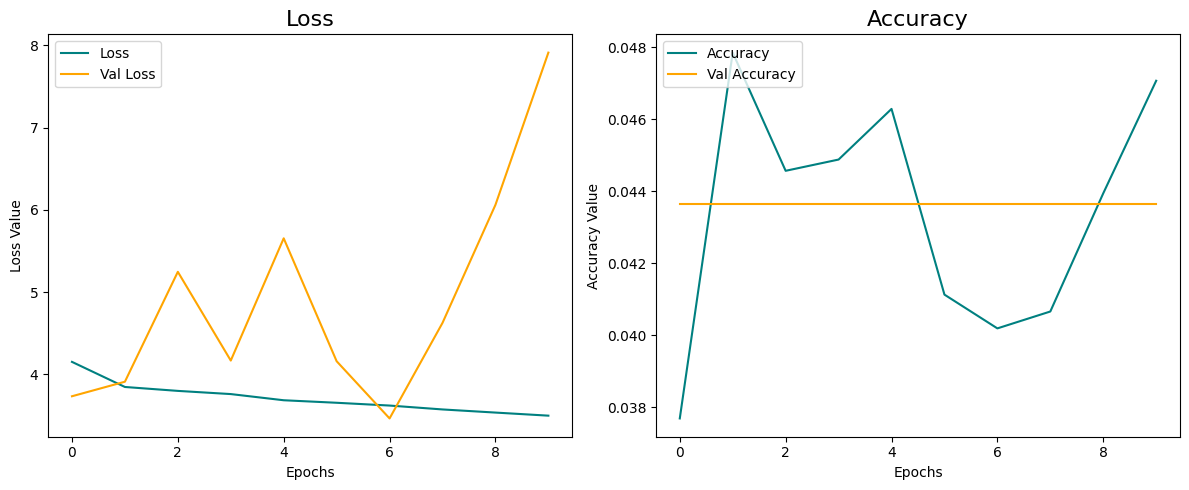

In [104]:
plot_loss_and_accuracy(hist)


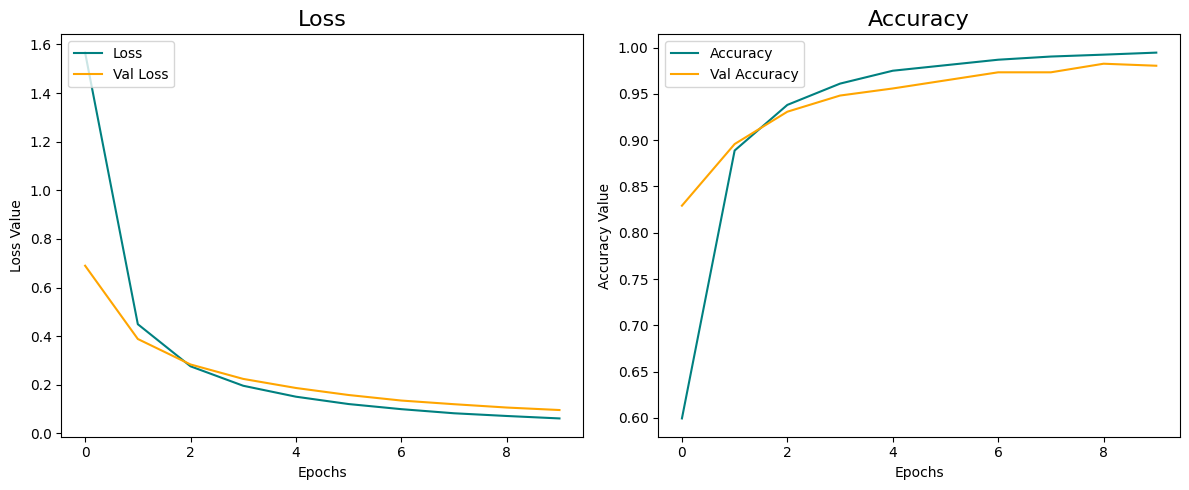

In [105]:
plot_loss_and_accuracy(mobilenetv2_hist)

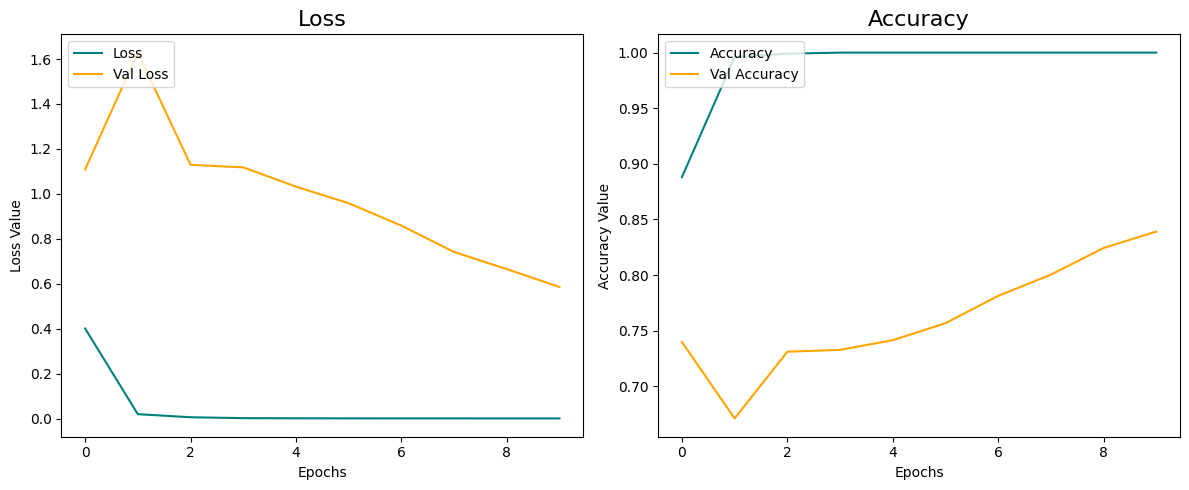

In [109]:
plot_loss_and_accuracy(mobilenetv2_finetune_hist)

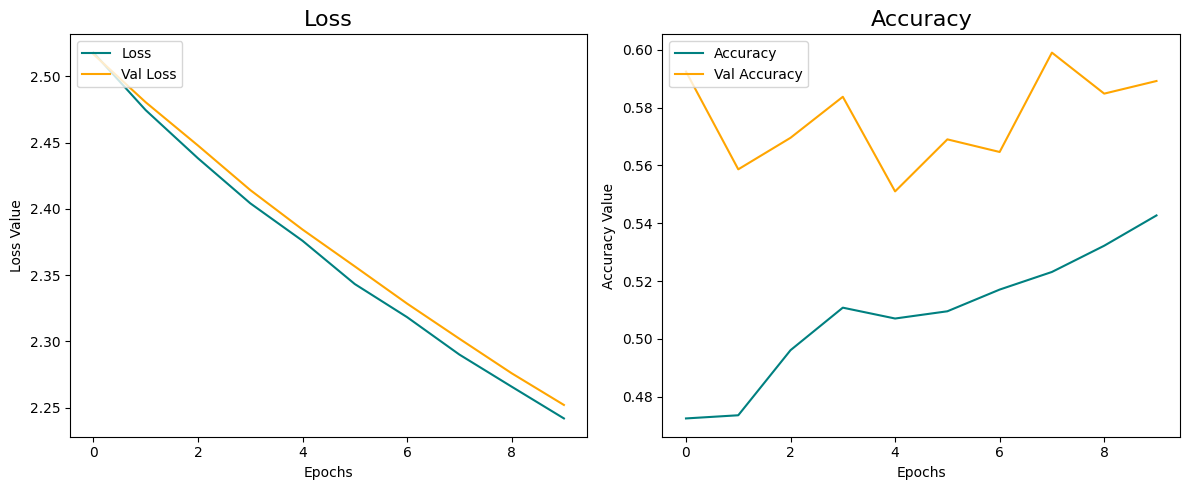

In [112]:
plot_loss_and_accuracy(hist4)